# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [12]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
        del X_train, y_train
        del X_test, y_test
        print('Clear previously loaded data.')
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg)
        
        preds_train = svm.predict(X_train_feats)
        preds_val = svm.predict(X_val_feats)

        acc_train = (preds_train == y_train).sum() / y_train.size
        acc_val = (preds_val == y_val).sum() / y_val.size
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
        
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.102857 val accuracy: 0.114000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.113306 val accuracy: 0.102000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.082265 val accuracy: 0.074000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.108327 val accuracy: 0.110000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.115000 val accuracy: 0.110000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.347735 val accuracy: 0.343000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.121673 val accuracy: 0.138000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.407918 val accuracy: 0.421000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.305776 val accuracy: 0.298000
best validation accuracy achieved during cross-validation: 0.421000


In [6]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


In [7]:
np.where((y_test != 1) & (y_test_pred == 1))

(array([  1,  15,  23,  40,  45,  62,  76, 101, 108, 111, 149, 150, 162,
        174, 191, 199, 211, 233, 259, 293, 335, 339, 343, 348, 349, 350,
        358, 383, 394, 399, 401, 417, 425, 451, 469, 480, 487, 496, 528,
        534, 539, 585, 587, 589, 595, 606, 611, 615, 621, 625, 626, 666,
        671, 675, 680, 683, 700, 725, 729, 732, 734, 741, 770, 780, 785,
        788, 790, 814, 853, 866, 881, 918, 930, 940, 949, 969]),)

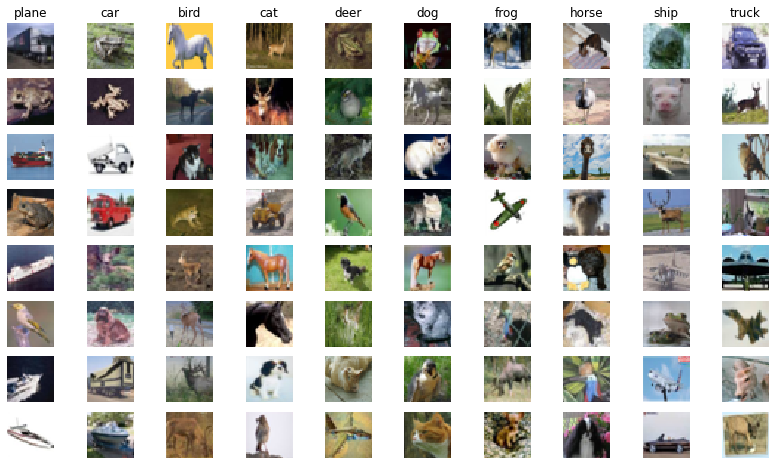

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]           # Returns a tuple (np.array,) -> unpack
    idxs = np.random.choice(idxs, examples_per_class, replace=False)     # Select 8 random indices where false positive
    for i, idx in enumerate(idxs):
        #               Doesn't work with **kwargs only with *args ...
        # So, subplot(nrows=.., ncols=.., index=..) does not work
        # Also the subplots will be filled vertically
        #               nrows               ncols               index
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

Yes, most of them make sense. One thing that is immediately recognizable, is the background color influencing the wrong decision. The other notable influence might be edges of the falsly classified object that resemble the edges of the images belonging to the predicted class.

E.g. many dogs were classified as horses, horses were classified as deer.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [26]:
def plot_results(stats, val_acc, lr, reg, drop_p):
    # Plot the loss function and train / validation accuracies
    fig = plt.figure(figsize=(12,10))
    fig.suptitle(f"LR: {lr:.2E}; REG: {reg:.2E}; DP: {drop_p:.2E}; Val acc: {val_acc:.2E}")
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [34]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
num_iters = 1500

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1

learning_rates = [5e-1]
regularization_strengths = [5e-4, 5e-5]
dropouts = [0.5, 1.0]

results = {}
losses = {}
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        for drop in dropouts:
            net = TwoLayerNet(input_dim, hidden_dim, num_classes, dropout_p=drop)
            loss = net.train(X_train_feats, 
                                                y_train, 
                                                X_val_feats, 
                                                y_val, 
                                                learning_rate=lr, 
                                                reg=reg, 
                                                num_iters=num_iters,
                                                learning_rate_decay=0.8,
                                                verbose=True)
            
            #scores_train = net.loss(X_train_feats)
            #preds_train = np.argmax(scores_train, axis=1)
            
            #scores_val = net.loss(X_val_feats)
            #preds_val = np.argmax(scores_val, axis=1)

            #acc_train = (preds_train == y_train).sum() / y_train.size
            #acc_val = (preds_val == y_val).sum() / y_val.size
            
            pred_train = net.predict(X_train_feats)
            pred_val = net.predict(X_val_feats)
            
            acc_train = (pred_train == y_train).sum() / y_train.size
            acc_val = (pred_val == y_val).sum() / y_val.size
            
            results[(lr, reg, drop)] = (acc_train, acc_val, loss)
            
            print(f"Train_acc: {acc_train:.2E}; Val_acc: {acc_val:.2E}; LR: {lr:.2E}; REG: {reg:.2E}; Drop: {drop:.2E}")
            
            if acc_val > best_val:
                best_val = acc_val
                best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 1.709132
iteration 200 / 1500: loss 1.569075
iteration 300 / 1500: loss 1.439358
iteration 400 / 1500: loss 1.309005
iteration 500 / 1500: loss 1.394723
iteration 600 / 1500: loss 1.252518
iteration 700 / 1500: loss 1.321310
iteration 800 / 1500: loss 1.236760
iteration 900 / 1500: loss 1.260917
iteration 1000 / 1500: loss 1.251206
iteration 1100 / 1500: loss 1.115464
iteration 1200 / 1500: loss 1.154344
iteration 1300 / 1500: loss 1.130130
iteration 1400 / 1500: loss 1.129966
Train_acc: 6.44E-01; Val_acc: 6.00E-01; LR: 5.00E-01; REG: 5.00E-04; Drop: 5.00E-01
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 1.701717
iteration 200 / 1500: loss 1.524068
iteration 300 / 1500: loss 1.503716
iteration 400 / 1500: loss 1.334477
iteration 500 / 1500: loss 1.251829
iteration 600 / 1500: loss 1.150549
iteration 700 / 1500: loss 1.211168
iteration 800 / 1500: loss 1.160177
iteration 900 / 1500: loss 1.147577
iteration 1000 

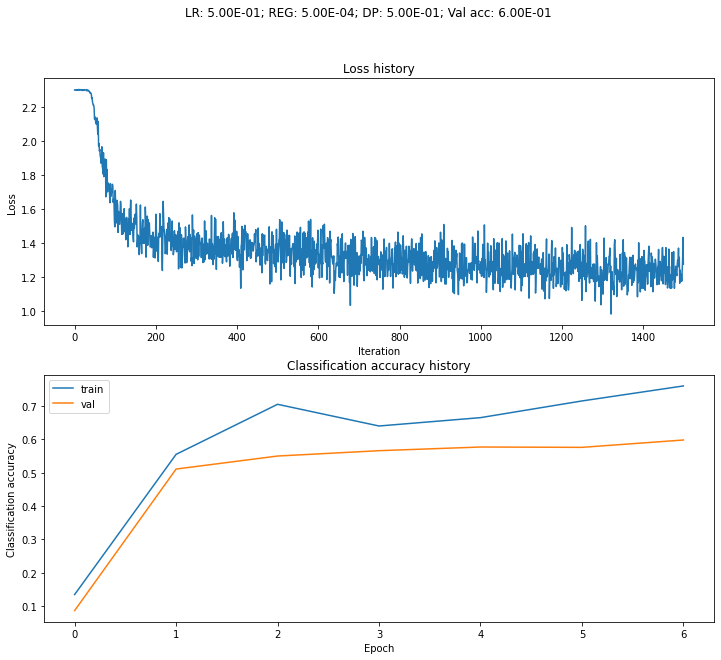

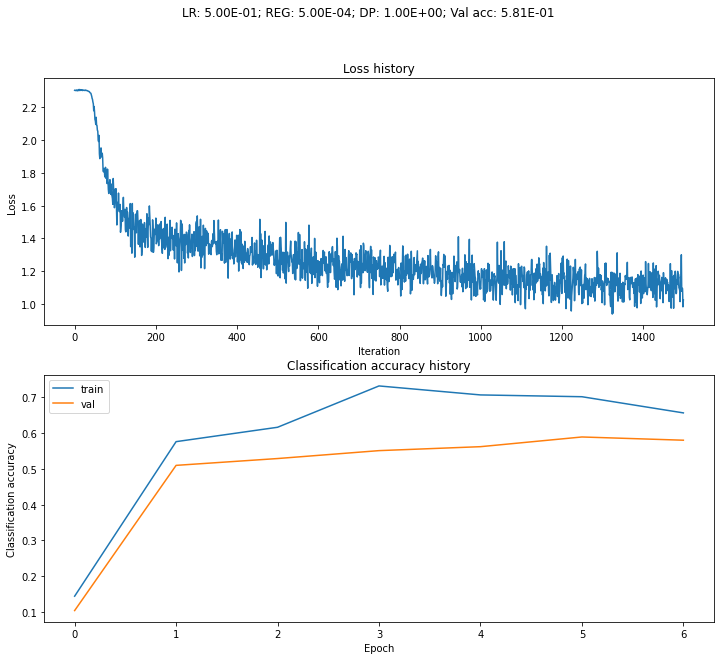

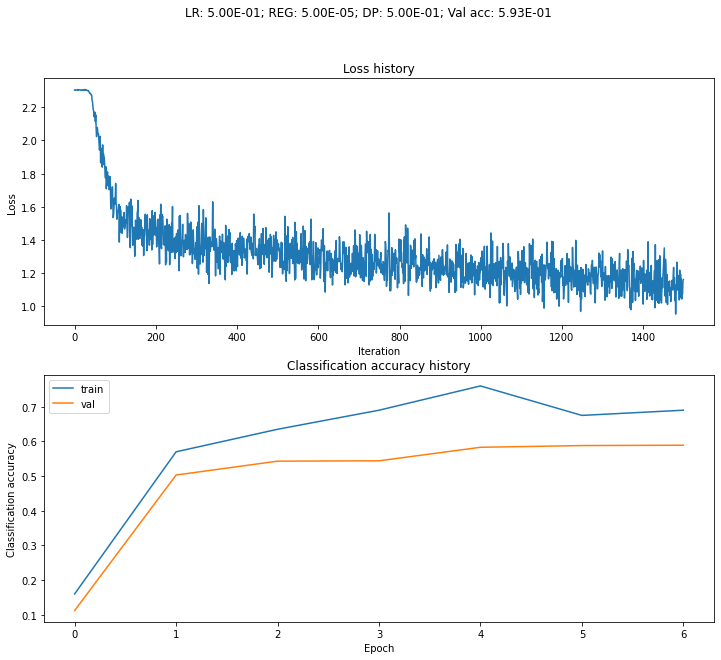

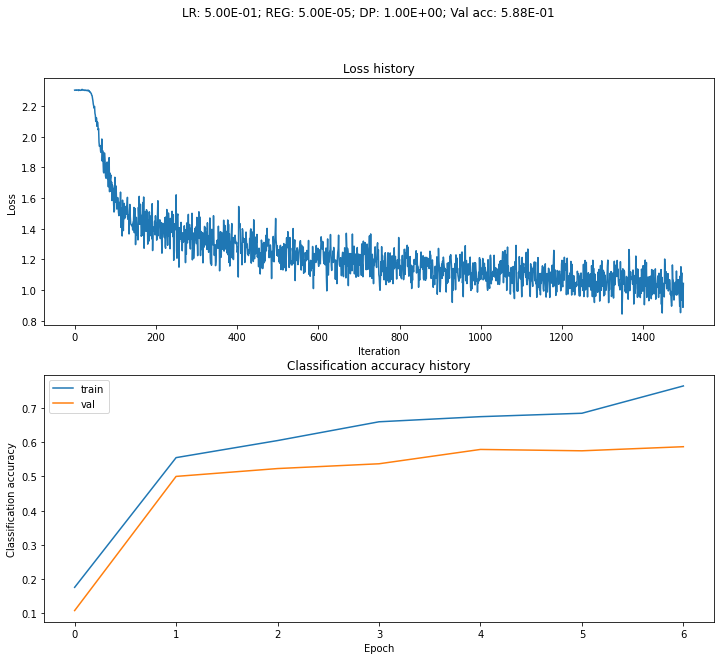

In [35]:
for key in results:
    lr, reg, drop = key
    acc_train, acc_val, loss = results[key]
    plot_results(loss, acc_val, lr, reg, drop)

In [36]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.58
